------------------------------------------------------------------------------------------------------------------------
### <b>Table of Content</b>

0. Background

1. Import functions

&emsp; <b>[ Voice Cloning (VC) ]</b>

2. Load data

3. Explore and prepare data<br>
    3-1. Examine labels<br>
    3-2. Prepare data for modeling<br>
    &emsp; 3-2-1. Merge data<br>
    &emsp; 3-2-2. Sample data<br>
    3-3. Explore audio data

4. Synthesize audio<br>
    4-1. Get source and target audio data<br>
    4-2. Copy original audio data to output folder<br>
    4-3. Concatenate multiple audios into a single target<br>
    4-4. Clone voice as per source and target<br>
    &emsp; 4-4-1. Select voice cloning models<br>
    &emsp; 4-4-2. Generate and save synthetic audio<br>
    4-5. Transcribe cloned voice<br>
    4-6. Build pipeline

5. Build multiclass classification model<br>
    5-1. Get train and test data<br>
    5-2. Normalize X and label-encode y<br>
    5-3. Build sequential neural network model<br>
    5-4. Evaluate model performance

6. Evaluate Voice Cloning (VC) system<br>
    6-1. Transcription quality<br>
    6-2. Classification accuracy

&emsp; <b>[ Fake Audio Detection (FAD) ]</b>

7. Load and process audio<br>
    7-1. Natural speeches<br>
    7-2. Synthetic speeches

8. Build binary classification model<br>
    8-1. Get train and test data<br>
    8-2. Build sequential neural network model<br>

9. Evaluate Fake Audio Detection (FAD) system

10. Conclusion
------------------------------------------------------------------------------------------------------------------------

### <b>0. Background</b>

This project is for a cyber security company providing products and services that can detect whether audio and video media is authentic or fake.

We are given two publically available corpora of speech data, which are the <a href="https://github.com/philipperemy/timit">TIMIT</a> and <a href="https://commonvoice.mozilla.org/en/datasets">CommonVoice</a> datasets. We will build two machine learning systems using these datasets as follows:

1. A voice cloning (VC) system that clones a given speaker's spoken audio to the target speaker's voice.
2. A fake audio detection (FAD) system that detects if any spoken audio is natural speech or synthetically generated by machines.

More details can be found in <a href="https://github.com/henryhyunwookim/K7h2vHrgG1Gl0S2r#readme">README</a>.

### <b>1. Import functions</b>

In [1]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from TTS.api import TTS

import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
from ordered_set import OrderedSet
import librosa
from librosa.display import waveshow
from IPython.display import Audio
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow_addons.metrics import F1Score

from utils.load import get_stratified_sample, get_variables_for_voice_cloning, get_concat_audio,\
                    get_X_and_y, get_label_dict, get_cloned_audio_paths, get_X_y_from_cloned_audio,\
                    get_result_df
from utils.save import copy_original
from utils.evaluate import transcribe_audio_and_evaluate, get_val_dict, get_mean_val_df, eval_neural_network
from utils.process import process_audio, clone_voice
from utils.split import custom_train_test_split
from utils.transform import normalize_scale, encode_label
from utils.plot import plot_audio_array, plot_callbacks_history
from utils.pipeline import clone_voice_and_evaluate
from utils.model import compile_and_fit_sequential_model
from utils.split import split_data

Using CPU for inference.



## <b>Voice Cloning (VC)</b>

#### <b>2. Load data</b>

Define file directories.

In [2]:
root_dir = Path(sys.path[0])

timit_dir = root_dir / 'data' / 'TIMIT' / 'archive'
common_voice_dir = root_dir / 'data' / 'CommonVoice' / \
    'cv-corpus-14.0-delta-2023-06-23-en.tar' / \
    'cv-corpus-14.0-delta-2023-06-23-en' / \
    'cv-corpus-14.0-delta-2023-06-23' / 'en'

main_output_dir= root_dir / 'output'
if not os.path.exists(main_output_dir):
    os.mkdir(main_output_dir)

target_concat_dir = main_output_dir / 'concat'
if not os.path.exists(target_concat_dir):
    os.mkdir(target_concat_dir)

Load CSV files.

In [3]:
train_csv = pd.read_csv(timit_dir / 'train_data.csv', index_col='index').dropna(how='all').reset_index(drop=True)
train_csv.index = train_csv.index.astype(int).astype(str)

test_csv = pd.read_csv(timit_dir / 'test_data.csv', index_col='index').dropna(how='any').reset_index(drop=True)
test_csv.index = test_csv.index.astype(int).astype(str)

train_csv.head()

,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
0,TRAIN,DR4,MMDM0,SI681.WAV.wav,TRAIN/DR4/MMDM0/SI681.WAV.wav,TRAIN\\DR4\\MMDM0\\SI681.WAV.wav,True,True,False,False,False
1,TRAIN,DR4,MMDM0,SI1311.PHN,TRAIN/DR4/MMDM0/SI1311.PHN,TRAIN\\DR4\\MMDM0\\SI1311.PHN,False,False,False,True,False
2,TRAIN,DR4,MMDM0,SI1311.WRD,TRAIN/DR4/MMDM0/SI1311.WRD,TRAIN\\DR4\\MMDM0\\SI1311.WRD,False,False,True,False,False
3,TRAIN,DR4,MMDM0,SX321.PHN,TRAIN/DR4/MMDM0/SX321.PHN,TRAIN\\DR4\\MMDM0\\SX321.PHN,False,False,False,True,False
4,TRAIN,DR4,MMDM0,SX321.WRD,TRAIN/DR4/MMDM0/SX321.WRD,TRAIN\\DR4\\MMDM0\\SX321.WRD,False,False,True,False,False


Audio and text files will be loaded based on the paths provided in the CSV files at the later steps.

#### <b>3. Explore and prepare data</b>

##### <b>3-1. Examine labels</b>

In [4]:
train_unique_speakers = OrderedSet(train_csv.speaker_id)
test_unique_speakers = OrderedSet(test_csv.speaker_id)
print(f'Number of speakers in train_csv: {len(train_unique_speakers)}')
print(f'Number of speakers in test_csv: {len(test_unique_speakers)}')
print(f'Total number of speakers: {len(train_unique_speakers) + len(test_unique_speakers)}')
print(f'Speakers that are found in both train_csv and test_csv: {train_unique_speakers & test_unique_speakers}')

Number of speakers in train_csv: 462
Number of speakers in test_csv: 168
Total number of speakers: 630
Speakers that are found in both train_csv and test_csv: OrderedSet()


As shown above, there's no overlap between speakers in the train and test sets. This means that any predictive model will not be able to predict the correct speakers when it was trained with the train data and then was fed the test data for making predictions since the speakers in the test data had never been seen during the training process.

For this reason, 'train_csv' and 'test_csv' will be combined and then later split into train and test sets to make a better use of the available data.

Additionally, as shown below, there are 10 audio files available for every speaker in both the train and test data.

In [5]:
train_num_wav_per_speaker = train_csv[train_csv['filename'].str.contains('WAV.wav')].value_counts('speaker_id').unique()
test_num_wav_per_speaker = test_csv[test_csv['filename'].str.contains('WAV.wav')].value_counts('speaker_id').unique()
print(f'Numbers of wav files for a single speaker in train_csv: {train_num_wav_per_speaker}')
print(f'Numbers of wav files for a single speaker in test_csv: {test_num_wav_per_speaker}')

Numbers of wav files for a single speaker in train_csv: [10]
Numbers of wav files for a single speaker in test_csv: [10]


##### <b>3-2. Prepare data for modeling</b>

##### 3-2-1. Merge data

Firstly, merge 'test_csv' with 'train_csv' for the aforementioned reasons.<br>
We will also add gender information as a new column based on speaker IDs.

In [6]:
merged_csv = pd.concat([train_csv, test_csv]).reset_index(drop=True)
merged_csv['gender'] = merged_csv['speaker_id'].apply(lambda x: 'male' if x[0] == 'M' else 'female')

<b>* Important considerations</b>

Before moving on, let's take a moment to contemplate the data we have and what we want to achieve using it.

We will need to build a classification model to assess the quality of synthesized voices by evaluating classification prediction results. This means the model will need to be reasonably accurate when predicting the correct label (that is, predicting the target speaker based on the cloned voice) out of 630 labels available in the data sets.

However, this will be extremely difficult for the following reasons:
- There are too many classes in the classification problem.
- We only have 10 audio files for each speaker, meaning the model can only learn from 10 files to make correct predictions.
- Each audio file is very short, around 2-3 seconds long.
- The quality of cloned voice would not be perfect because voice cloning models will synthesize voice based on very short audio data, which will make the classification model even more difficult to make correct predictions.

Simply put, we need to build a multiclass classification model where there are too many classes (or speakers), while we need to clone voices and build a classification model using very little data (i.e., 10 audio files for each class/speaker).

To deal with these challenges, the following will be done:
- Concatenate 10 different audio files for each speaker so that voice cloning models can synthesize voice based on more (or longer) audio data.
- For training the classification model, limit the number of speakers to a small number so that it will be easier for it to make more accurate predictions. That is, it will be easier to predict the correct speaker out of 10 different speakers than 600+ different speakers.
- Compare different voice cloning models (17 models in total) and pick the best-performing ones so that the classification accuracy would be better.

##### 3-2-2. Sample data

Now, get samples stratified by gender with a small number of speakers for voice cloning and model building.<br>
* If the value of the 'num_sample_per_gender' variable below is 2, there will be 2 male and female speakers each (in total 4 speakers) in the sampled data.

In [7]:
num_sample_per_gender = 2
save_dir = root_dir / 'saved'
stratified_sample_df_path = f'{save_dir}/stratified_sample_df.csv'

stratified_sample_df = get_stratified_sample(
    stratified_sample_df_path,
    merged_csv,
    groupby='gender',
    label_col='speaker_id',
    num_sample_per_lebel=num_sample_per_gender)

stratified_sample_df loaded from CSV.


Get labels (or categories, classes), which are unique speaker IDs in the data.

In [8]:
unique_labels = set(stratified_sample_df['speaker_id'])
num_labels = len(unique_labels)
print(f'Number of unique speakers/labels in merged_csv: {num_labels}')

Number of unique speakers/labels in merged_csv: 4


Define mapping dictionaries for encoding (and decoding) the speaker IDs from string to integer so that machine learning models can understand the labels.

In [9]:
speaker_id_dict_path = save_dir / 'speaker_id_dict.json'
speaker_id_dict, reverse_speaker_id_dict = get_label_dict(speaker_id_dict_path, unique_labels)

Existing label dict loaded from d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\saved\speaker_id_dict.json.


##### <b>3-3. Explore audio data</b>

Get paths to audio files that are in 'wav' form from the stratified samples.<br>
Also, get an example audio path for exploration.

In [10]:
audio_paths = stratified_sample_df[stratified_sample_df['is_converted_audio']==True]['path_from_data_dir'].drop_duplicates().reset_index(drop=True)
audio_dir = timit_dir / 'data'

example_audio_path = audio_dir / audio_paths[0]
example_audio_path

WindowsPath('d:/OneDrive/GitHub/Apziva/K7h2vHrgG1Gl0S2r/data/TIMIT/archive/data/TRAIN/DR5/MMDM1/SI783.WAV.wav')

Play the example auido after loading it as an array.

In [11]:
audio_array, sample_rate = \
    librosa.load(example_audio_path, sr=None) # sr: sampling rate, or samples per second. default 22050.
Audio(data=audio_array, rate=sample_rate)

Visualize the audio array as a waveform in the time domain, where the y axis represents amplitude.

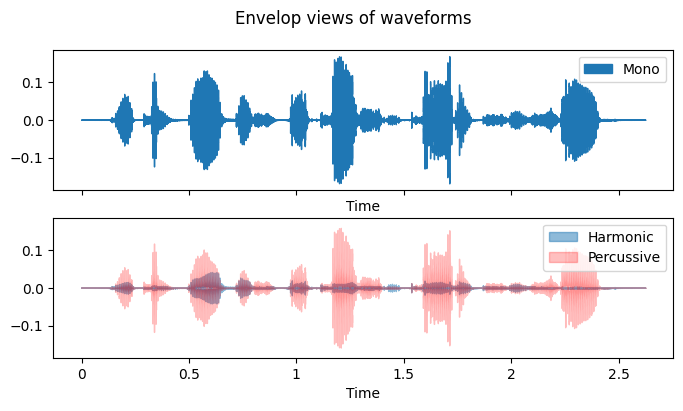

In [12]:
%matplotlib inline
plot_audio_array(row=2, col=1, figsize=(8, 4), sharex=True, sharey=True,
                audio_array=audio_array, sample_rate=sample_rate,
                title='Envelop views of waveforms')

#### <b>4. Synthesize audio</b>

##### <b>4-1. Get source and target audio data</b>

Get relevant details of the source and target audio files from the stratified samples.<br>
The source and target audios are randomly taken from the stratified samples.

In [13]:
# sampled = audio_paths.sample(n=2, replace=False)
# source_audio_subpath = sampled.iloc[0]
# target_audio_subpath = sampled.iloc[1]

# source_speaker_id, source_audio_file, source_file_id, source_audio_path,\
# target_speaker_id, target_audio_file, target_file_id, target_audio_path,\
# source_text_file, source_text_path, source_text, output_dir, output_filename\
#     = get_variables_for_voice_cloning(
#         source_audio_subpath, target_audio_subpath, root_dir, timit_dir, stratified_sample_df)

##### <b>4-2. Copy original audio data to output folder</b>

Copy original source and target files to the output folder where cloned audios will be stored so that it will be easier when evaluating cloned audio files in the output file.

In [14]:
# copy_original(output_dir,
#             source_audio_file, source_audio_path,
#             target_audio_file, target_audio_path,
#             source_text_file, source_text_path)

##### <b>4-3. Concatenate multiple audios into a single target</b>

As mentioned earlier, each audio file we have is very short - only 2-3 seconds long.<br>
Thus, it can be better to have longer audio files by concatenating different audio files from the same speaker as a single target audio (or reference) for cloning. Voice cloning models can then take more information or different features from a longer audio than from a 2-3 second-long audio, which would help improve the quality of cloned audio.

In [15]:
# concat_target_audio_path = get_concat_audio(target_audio_path, target_concat_dir, target_speaker_id,
#                                             add_silence=0, n_duplicate_concat=1)

When cloning audios using the 'get_concat_audio' function above, users can
- Add silence among audio files by specifying the 'add_silence' variable in milliseconds.<br>
- Further duplicate audio files by specifying the 'n_duplicate_concat' variable (default is 1, meaning no duplication of the concatenation). For example, if the value is 2, the list of audio files by the target speaker (i.e., 10 different audio files for any speaker) will be shuffled and concatenated twice to form the final target audio.

Notwithstanding these options, they were not found to be very helpful for our purposes based on preliminary experiments.<br>
Hence, no silence will be added among audio files, and each audio will be included in the concatenated audio only once when concatenating audio files in this project.

##### <b>4-4. Clone voice as per source and target</b>

##### 4-4-1. Select voice cloning models

It's time to clone voice, given 
- The target speaker's spoken audio
- The source speaker's spoken audio or the transcription of the audio, depending on the voice cloning model used.

For this process, 17 different voice cloning (or speech generation) models from open-source packages as below have been tried out:<br>
- 'speech_generator' from <a href='https://pypi.org/project/Voice-Cloning/'>Voice_Cloning</a>
- 16 different models from <a href='https://github.com/coqui-ai/tts'>TTS by Coqui.ai</a>
    - Multilingual model: 'freevc24'
    - English-language models: 'capacitron-t2-c150_v2', 'capacitron-t2-c50',<br>
    'fast_pitch', 'glow-tts', 'jenny', 'neural_hmm', 'overflow', 'speedy-speech',<br>
    'tacotron', 'tacotron2', 'tacotron2-DCA', 'tacotron2-DDC_ph', 'tacotron-DDC',<br>
    'vits', 'vits--neon'

Synthetic audios generated by these were evaluated during preliminary experiments based on the following measures:
- Quality of transcription of the synthesized audio
    - The quality will be perfect when the source text and the transcribed speech (both in lowercase) are identical, excluding whitespaces and punctuation. More details about the evaluation metrics are included in the next section.
    - These models often performed better than the others:<br>
    'fast_pitch', 'jenny', 'tacotron2-DDC_ph', 'tacotron2-DDC', 'vits', 'vits--neon'
- Prediction accuracy by the classification model
    - The accuracy will be perfect when the classification model always predicts the correct label (or the target speaker) of the cloned audio.
    - The classification model correctly predicted the labels of the cloned audios generated by the 'speech_generator' more often than the rest. While there were no notable differences among the rest of the models, some group of models such as the 'vits' model was sometimes somewhat better, following the 'speech_generator'.

Based on the above evaluation measures and results, the below two models were selected and will be used in the next stages.
- 'vits' from TTS: Produced one of the best transcription quality and somewhat better classification accuracy
- 'speech_generator' from voice_cloning: Produced the best classification accuracy but also the worst transcription quality

##### 4-4-2. Generate and save synthetic audio

The 'clone_voice' function below generates synthesized speeches with the voice of the target speaker based on either the source text or source audio (i.e., the short speech by the source speaker) and saves the cloned voice to 'output_dir'. Below are optional arguments to the function call:
- tools: Tools or libraries to use for voice cloning. Available options are 'voice_cloning', 'multi-tts', and 'en_tts', where the latter two are from the TTS API by Coqui.
- en_tts_models: Only relevant when 'en_tts' is one of the tools to use. This is a list of TTS models to use for cloning voice in English.
- noise_reduction: Only for the model from 'voice_cloning'. If True, noise reduction will be applied when saving generated speech.
- adjust_decibel: Only for the models from TTS. If not 0, the volume of the generated speech will be adjusted accordingly.
- progress_bar: Only for the models from TTS. If True, show progress bars while cloning voice.
- gpu: Only for the models from TTS. If True, use GPU, if available, when cloning voice.

In [16]:
# clone_voice(str(concat_target_audio_path),
#             str(source_audio_path),
#             source_text,
#             output_dir, output_filename,
#             tools=['voice_cloning', 'en_tts'],
#             en_tts_models=['vits'],
#             noise_reduction=True, adjust_decibel=0, progress_bar=False, gpu=True
#             )

##### <b>4-5. Transcribe cloned voice</b>

The main success metric for evaluating the voice cloning (VC) system for the speech generation part is the Word Error Rate (WER). However, we are going to use a few more metrics, which are often used for measuring the speech-to-text accuracy of Automatic Speech Recognition (ASR) systems, or for measuring the accuracy of machine translation systems, for a more balanced evaluation as follows:

1. Word Error Rate (WER):<br>
    The number of errors divided by the total words, hence the lower the better.<br>
    Generally speaking, a WER of 5% would signify a good accuracy of the system.

2. Match Error Rate (MER):<br>
    The probability of a given match being incorrect.<br>
    The lower the rate, the more accurate the system that is being evaluated (e.g., an ASR system).

3. Word Information Lost (WIL):<br>
    The amount of information lost in the generated text (i.e., transcription of a cloned voice in our case) divided by the total amount of information contained in the reference text (i.e., the source text).<br>
    The lower the better, and it is generally considered a more sophisticated measure than WER.

4. Word Information Preserved (WIP):<br>
    This is very similar to WIL but it represents the proportion of information preserved, instead of information lost.<br>
    The higher the better, and the sum of the WIP and WIL is usually equal to 1.

5. Character Error Rate (CER):<br>
    The percentage of errors in characters, as opposed to words for calculating WER.<br>
    The "characters" here not only include letters but also whitespaces and punctuation.
    Similar to WER, the lower the better.<br>

As a matter of fact, these are the measures used by the functions from the <a href='https://pypi.org/project/jiwer/'>JiWER</a> package, which was used for this process in this project.

The 'transcribe_audio_and_evaluate' function below will
- Load the cloned file from 'output_dir'.
- Transcribe the loaded audio.
- Clean the transcription - converting to lowercase, removing whitespaces and punctuation.
- Compare the source text and the transcription of the cloned audio to get the statistics that are detailed above.
- Return a dictionary containing the statistics, in addition to the source text and transcription for each of the cloned audio in 'output_dir'.

In [17]:
# eval_dict = transcribe_audio_and_evaluate(output_dir, output_filename, source_text)
# eval_df = pd.DataFrame(eval_dict).T
# eval_df

##### <b>4-6. Build pipeline</b>

Create a function called 'clone_voice_and_evaluate' that performs the steps from 4-1 to 4-5.<br>
Call the function 'n' times as specified by the 'n' variable below to generate synthetic audio files according to different pairs of source and target speakers.

In [18]:
# %%capture captured
# The outputs can be accessed by calling captured().

n = 10
concat_eval_path = f'{save_dir}/concat_eval_df.csv'

concat_eval_df, eval_cols = clone_voice_and_evaluate(
    concat_eval_path, n, audio_paths, root_dir, timit_dir, stratified_sample_df, target_concat_dir,
    add_silence=0, n_duplicate_concat=1, vc_tools=['voice_cloning', 'en_tts'], en_tts_models=['vits'],
    noise_reduction=True, adjust_decibel=0, progress_bar=False, gpu=True)

concat_eval_df loaded from CSV.


The transcription quality of cloned voices will be evaluated in section 6-1.

#### <b>5. Build multiclass classification model</b>

##### <b>5-1. Get train and test data</b>

To assess the performance of the VC system (or the quality of the cloned audios), we need a classification model that can predict the target speakers based on the synthetic speeches. That is to say that we are going to train (and validate) a classification model using original audio data and predict the labels (or classes or target speakers) of synthesized audio data.

For training a model, we will extract Mel-Frequency Cepstral Coefficients (MFCC) from each audio file, which essentially is a set of features representing frequency distribution and time characteristics of audio data, to form train and test data sets. The MFCC is often used for speech recognition or other similar tasks.

The 'get_X_and_y' function below will transform audio files in 'audio_path' into train and test data sets.
- The number of MFCCs to return can be specified by the 'n_mfcc' argument. If 40, the returned data will have 40 features (or columns).
- The proportion of data for training (and testing) can be specified by the 'train_size' argument. If 0.8, 80% of the audio files will be used for training and the remaining 20% for testing (or validation).

In [19]:
n_mfcc = 40
train_size = 0.8
label_col = 'label'

train_X_path = f'{save_dir}/train_X.csv'
test_X_path = f'{save_dir}/test_X.csv'
train_y_path = f'{save_dir}/train_y.csv'
test_y_path = f'{save_dir}/test_y.csv'

train_X, test_X, train_y, test_y = get_X_and_y(
    train_X_path, test_X_path, train_y_path, test_y_path, audio_paths, audio_dir,
    label_col=label_col, n_mfcc=n_mfcc, train_size=train_size)

CSV files already exist. Skipping processing audio data.
CSV files loaded as data frames.


##### <b>5-2. Normalize X and label-encode y</b>

In [20]:
train_X.describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,-396.408157,59.276917,-26.002349,2.590275,-28.990571,-14.505678,-16.181518,-15.694546,-5.081195,-12.223341,...,1.681042,1.529158,2.000157,0.942464,1.115553,0.119639,-0.165187,-0.985237,-0.871000,-1.708623
std,41.913923,15.644164,13.132459,14.187053,7.667728,5.435044,7.715024,11.263451,4.279317,6.122682,...,5.368722,5.715642,5.223622,6.097686,4.623236,4.281087,3.605181,3.043752,2.900591,1.823447
min,-475.321470,15.206354,-54.557938,-26.930216,-39.022785,-26.624868,-30.201500,-38.682980,-13.804020,-22.207293,...,-6.821986,-4.584202,-4.538958,-5.947828,-5.244397,-5.331673,-5.694336,-8.009023,-5.178691,-5.370231
25%,-435.633650,52.427403,-31.363051,-8.794009,-34.362023,-17.547622,-22.295177,-26.284222,-7.161651,-16.807404,...,-2.819818,-3.671558,-2.189723,-3.993003,-2.801729,-3.339762,-3.195858,-3.385625,-3.202831,-3.118852
50%,-385.875945,62.414436,-24.864863,3.962541,-30.604861,-15.074749,-17.825324,-13.439243,-5.403847,-13.133108,...,0.787323,-1.174866,-0.467136,-1.815468,-0.764028,-1.244503,-1.203624,-1.100895,-1.218131,-1.495418
75%,-365.145065,68.100977,-21.338090,12.481986,-26.372871,-10.902525,-10.334512,-5.629537,-2.447447,-6.090436,...,5.595977,5.661380,6.318118,5.918081,5.142034,3.016325,2.614693,1.721926,1.349857,-0.611177
max,-330.545750,96.180840,2.868017,25.220130,-10.247083,-3.933731,2.129308,0.632912,3.914252,0.029202,...,12.435634,15.142719,13.666658,15.682538,12.269709,10.927046,6.632840,5.337164,5.462866,2.781866


As you can see above, different features are in different scales, which will make the neural network model that we are going to train difficult to converge. Thus, the features (i.e., 'train_X' and 'test_X') would need to be normalized before being fed to the model so that the convergence would be faster and more stable without getting stuck in local optima during training.

The 'normalize_scale' function below will normalize scales using StandardScaler from sklearn (or scikit-learn).

In [21]:
normalized_train_X, normalized_test_X, scaler\
    = normalize_scale(train_X, test_X, method="standard")
normalized_train_X.describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,...,3.200000e+01,32.000000,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01
mean,9.228729e-16,-6.245005e-17,1.040834e-17,2.775558e-17,-1.387779e-16,1.110223e-16,-5.551115e-17,-7.632783e-17,-1.110223e-16,1.804112e-16,...,-1.387779e-17,0.000000,4.163336e-17,2.081668e-17,2.775558e-17,-5.551115e-17,-4.163336e-17,1.387779e-17,-3.469447e-17,-1.387779e-17
std,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00,...,1.016001e+00,1.016001,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00
min,-1.912873e+00,-2.862137e+00,-2.209221e+00,-2.114100e+00,-1.329304e+00,-2.265503e+00,-1.846309e+00,-2.073634e+00,-2.070984e+00,-1.656742e+00,...,-1.609151e+00,-1.086699,-1.271866e+00,-1.148066e+00,-1.397661e+00,-1.293722e+00,-1.558208e+00,-2.344532e+00,-1.508871e+00,-2.040200e+00
25%,-9.508330e-01,-4.448377e-01,-4.147341e-01,-8.152817e-01,-7.117364e-01,-5.686463e-01,-8.051153e-01,-9.552242e-01,-4.939444e-01,-7.606819e-01,...,-8.517627e-01,-0.924469,-8.149370e-01,-8.223513e-01,-8.608610e-01,-8.209958e-01,-8.540944e-01,-8.012468e-01,-8.167794e-01,-7.857613e-01
50%,2.553027e-01,2.037643e-01,8.800227e-02,9.827438e-02,-2.138991e-01,-1.063794e-01,-2.164748e-01,2.034359e-01,-7.660435e-02,-1.509673e-01,...,-1.691314e-01,-0.480662,-4.798916e-01,-4.595286e-01,-4.130563e-01,-3.237423e-01,-2.926492e-01,-3.860656e-02,-1.215909e-01,1.187951e-01
75%,7.578230e-01,5.730734e-01,3.608533e-01,7.083916e-01,3.468546e-01,6.735561e-01,7.699994e-01,9.078975e-01,6.253081e-01,1.017697e+00,...,7.408798e-01,0.734535,8.398489e-01,8.290411e-01,8.848581e-01,6.874507e-01,7.834170e-01,9.036482e-01,7.779081e-01,6.114823e-01
max,1.596517e+00,2.396704e+00,2.233574e+00,1.620629e+00,2.483578e+00,1.976269e+00,2.411375e+00,1.472791e+00,2.135711e+00,2.033193e+00,...,2.035247e+00,2.419919,2.269149e+00,2.456002e+00,2.451234e+00,2.564848e+00,1.915799e+00,2.110411e+00,2.218587e+00,2.502042e+00


Another thing to do before modeling is to convert speaker IDs in alphanumeric characters into numbers so that machine learning algorithms can understand the labels (i.e., speaker IDs).

To achieve this, LabelEncoder from sklearn and other available encoding methods were tried out. However, it was found that the encoder doesn't always return the same numbers for the same speaker IDs, especially when the total number of labels in new data (i.e., in our case, cloned audio data), which was unseen by the model during training, is different from the number of labels in the training data.

For this reason, we will manually encode labels using the mapping dictionary created earlier so that we will always get the exact same encoded labels as long as the input labels in alphanumeric characters are found in the dictionary, and vice versa - i.e., when inputting encoded numbers to get alphanumeric speaker ID.

In [22]:
sparse_train_y, sparse_test_y\
    = encode_label([train_y, test_y], mapping_dict=speaker_id_dict, num_labels=num_labels)
train_y.values[:5], sparse_train_y[:5]

(array(['MWEW0', 'MWEW0', 'FAWF0', 'FAWF0', 'MMDM1'], dtype=object),
 array([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]]))

##### <b>5-3. Build sequential neural network model</b>

Now we are ready to build a sequential neural network model, which is a common choice for audio classification tasks. The process of hyperparameter tuning was long and extensive, thus is not detailed in this notebook. Please also note that the hyperparameters defined below may not work as fine as in this project since they were optimized for the specific objectives and data we had.

The 'compile_and_fit_sequential_model' function below will load the saved model and results if they exist in local drive. Otherwise, it will build a sequential model and return the model object and the history object that contains the details of each epoch during the training process.

In [23]:
num_layers = 7
units_list = [1024, 1024, 1024, 1024, 1024, 1024, num_labels]
activation_list = ['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'softmax']
input_shape = (train_X.shape[1],)
dropout_rate = 0.5
learning_rate = 0.01
optimizer = Adam(lr=learning_rate)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
num_batch_size = 64
num_epochs = 20

best_model_path = f'{save_dir}/audio_classification.h5'
best_result_path = f'{save_dir}/audio_classification.json'
# checkpoint_path = f'{save_dir}/audio_classification.hdf5'

model, history = compile_and_fit_sequential_model(
    best_model_path, best_result_path, 
    num_layers, num_labels, units_list, activation_list,
    input_shape, dropout_rate, optimizer, loss, metrics,
    normalized_train_X, sparse_train_y, normalized_test_X, sparse_test_y,
    num_batch_size, num_epochs, checkpointer=None)
model.summary()

Load saved model and results from drive.
Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_435 (Dense)           (None, 1024)              41984     
                                                                 
 dropout_325 (Dropout)       (None, 1024)              0         
                                                                 
 dense_436 (Dense)           (None, 1024)              1049600   
                                                                 
 dropout_326 (Dropout)       (None, 1024)              0         
                                                                 
 dense_437 (Dense)           (None, 1024)              1049600   
                                                                 
 dropout_327 (Dropout)       (None, 1024)              0         
                                                                 
 dense_438 

##### <b>5-4. Evaluate model performance</b>

Evaluate the model using test data.

In [24]:
eval_neural_network(model, normalized_test_X, sparse_test_y, history, eval_metric='accuracy')

1/1 [==============================] - 1s 870ms/step - loss: 0.0314 - accuracy: 1.0000
Test loss: 0.031418345868587494
Test accuracy: 1.0

Best loss: 0.1618
Best accuracy: 0.9375
Best val_loss: 0.0314
Best val_accuracy: 1.0


The validation accuracy is 1.0, which is not realistic in practice, although there was no obvious data leakage or overfitting. This is likely due to the small number of instances in the validation set, but there is no need to dig further into this for now since we only want to verify if the cloned voices will be classified as the correct target speakers with reasonably good accuracy.

Let us also visualize the loss and accuracy values at each epoch in line charts by running the cell below.

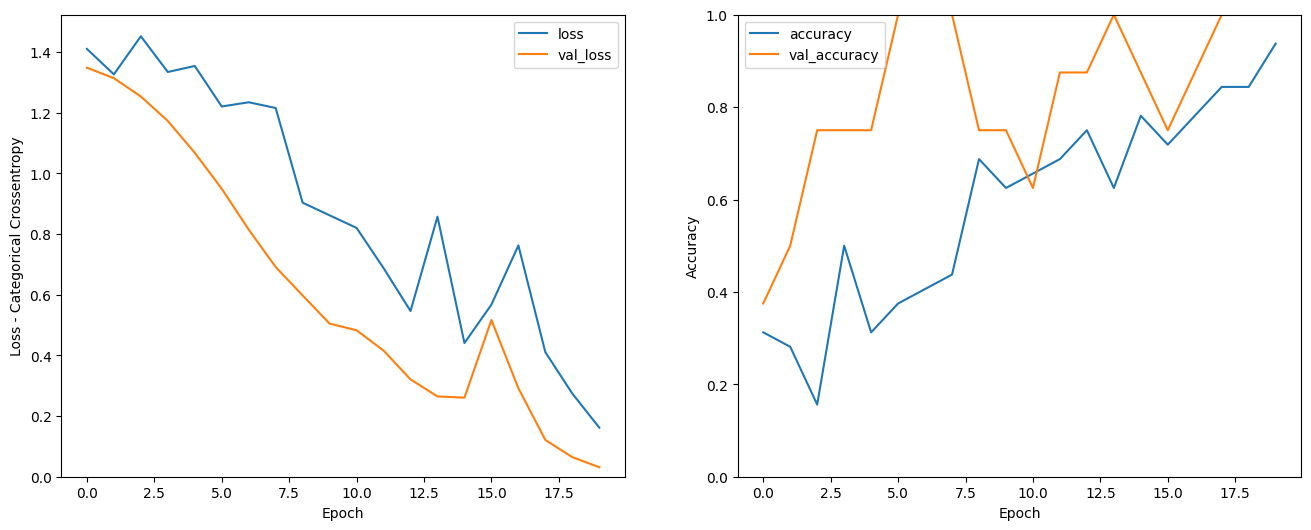

In [25]:
%matplotlib inline
plot_callbacks_history(history, figsize=(16, 6), eval_metrics=['Categorical Crossentropy', 'Accuracy'])

We would also want to look at label-level results in case of imbalanced performance across different labels.<br>
The 'get_val_dict' function below will create a dictionary containing validation scores for each label.

In [26]:
val_dict_path = f'{save_dir}/val_dict.json'
val_dict = get_val_dict(normalized_test_X, test_y, sparse_test_y, val_dict_path, model)
val_dict

val_dict already exists. Loading from d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\saved/val_dict.json


{'FAWF0': {'val_loss': [0.0413, 0.0182], 'val_accuracy': [1.0, 1.0]},
 'MMDM1': {'val_loss': [0.0645, 0.0997], 'val_accuracy': [1.0, 1.0]},
 'FLAG0': {'val_loss': [0.0204, 0.0067], 'val_accuracy': [1.0, 1.0]},
 'MWEW0': {'val_loss': [0.0004, 0.0002], 'val_accuracy': [1.0, 1.0]}}

Get the mean of each metric so that each label will have only one score for each of the metrics.

In [27]:
mean_val_df = get_mean_val_df(val_dict)
mean_val_df

,val_loss,val_accuracy
MWEW0,0.00030,1.0
FLAG0,0.01355,1.0
FAWF0,0.02975,1.0
MMDM1,0.08210,1.0


To conclude this section, the trained neural network model was able to predict all four labels with 100% accuracy.<br>
The model will try to predict the labels of the cloned audio data in a later section.

### <b>6. Evaluate Voice Cloning (VC) system</b>

##### <b>6-1. Transcription quality</b>

Now that we have built the voice cloning (VC) system, it's time to evaluate it.

Firstly, we will evaluate how accurate the transcriptions of the cloned audios are. This is a less direct way to evaluate the quality of the VC system as we are not evaluating what was spoken in each audio directly and the transcriptions might not be perfectly accurate. However, this may probably be the only way with current technology and as a matter of fact this method is often used when evaluating Automatic Speech Recognition (ASR) systems or machine translation systems in practice, which are similar to our application.

The evaluation measures used here are as follows and more details can be found from section 4-5 above.

1. Word Error Rate (WER) - the <i>lower</i> the better
2. Match Error Rate (MER) - the <i>lower</i> the better 
3. Word Information Lost (WIL)  - the <i>lower</i> the better
4. Word Information Preserved (WIP) - the <i><b>higher</b></i> the better
5. Character Error Rate (CER) - the <i>lower</i> the better

The below 'concat_eval_df' is already sorted according to better scores, so the results on the top rows mean the transcriptions were the most accurate among other cloned audios. As you can see, the top 5 results were perfect, meaning the transcriptions match exactly the source texts.

In [28]:
concat_eval_df.head()

,wer,mer,wil,wip,cer,Transcription,Source Text,model
0,0.0,0.0,0.0,1.0,0.0,a few years later the dome fell in,a few years later the dome fell in,vits
1,0.0,0.0,0.0,1.0,0.0,dont ask me to carry an oily rag like that,dont ask me to carry an oily rag like that,vits
2,0.0,0.0,0.0,1.0,0.0,a few years later the dome fell in,a few years later the dome fell in,vits
3,0.0,0.0,0.0,1.0,0.0,the cartoon features a muskrat and a tadpole,the cartoon features a muskrat and a tadpole,vits
4,0.0,0.0,0.0,1.0,0.0,should giraffes be kept in small zoos,should giraffes be kept in small zoos,vits


The below table contains the mean of each evaluation score for each voice cloning model that was used to synthesize audios.
According to the scores, the 'vits' model's performance was clearly better than the 'vc' model across all evaluation metrics. Although the 'vc' model's performance was kind of mediocre, the 'vits' model performed pretty well with some perfect transcriptions.

In [29]:
concat_eval_df.groupby('model').mean().sort_values(eval_cols, ascending=[True, True, True, False, True])

,wer,mer,wil,wip,cer
model,,,,,
vits,0.120357,0.105649,0.151904,0.848096,0.043256
vc,0.340357,0.325942,0.417635,0.582365,0.257928


##### <b>6-2. Classification accuracy</b>

Secondly, we will evaluate whether the classification model from section 5-3 can accurately predict the speaker of cloned voices. Since the classification model's validation accuracy was perfect, a good prediction accuracy score in this section would mean a high quality of cloned voices, meaning the voices were cloned well enough that the classification model can accurately predict the target speaker.

In [30]:
X, y, wav_path_list = get_X_y_from_cloned_audio(main_output_dir, n_mfcc, label_col)

In [31]:
normalized_X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)
sparse_y = encode_label([ y[label_col] ], mapping_dict=speaker_id_dict, num_labels=num_labels)[0]
model.evaluate(normalized_X, sparse_y)

2/2 [==============================] - 1s 33ms/step - loss: 0.6087 - accuracy: 0.8333


[0.6087403893470764, 0.8333333134651184]

The prediction accuracy of the speakers of the cloned audio files was 83.3%. Although it is less than 90%, the model was able to make reasonably accurate predictions, considering we only had 10 audio files for each of the speakers for both training and validation processes.<br>
A good prediction accuracy score here also means that the VC system was able to synthesize the target speaker's voices with good quality.

Lastly, below is a snippet of the results for reference, containing true and predicted labels and other useful details.

In [32]:
result_df = get_result_df(model, normalized_X, y, label_col, speaker_id_dict, reverse_speaker_id_dict, wav_path_list)
result_df.sort_values('matched', ascending=False).head()    

2/2 [==============================] - 0s 28ms/step


,label,code,pred_label,pred_code,pred_prob,matched,model_name,source_speaker,source_script,target_speaker,target_script,wav_path
0,MWEW0,2,MWEW0,2,0.630418,True,vc,FAWF0,SA2,MWEW0,SI1991,d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\out...
29,MWEW0,2,MWEW0,2,0.921800,True,vits,MMDM1,SA1,MWEW0,SI731,d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\out...
31,MWEW0,2,MWEW0,2,0.845278,True,vits,MMDM1,SA1,MWEW0,SX191,d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\out...
32,MWEW0,2,MWEW0,2,0.897785,True,vc,MMDM1,SI2043,MWEW0,SA1,d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\out...
33,MWEW0,2,MWEW0,2,0.874695,True,vits,MMDM1,SI2043,MWEW0,SA1,d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\out...


## <b>Fake Audio Detection (FAD)</b>

Next is to build a fake audio detector that can distinguish whether a given audio is spoken by human or synthetically generated by machine, which is essentially a binary classification model.<br>
To train such a model, we need a set of natural speeches as positive samples (or with true labels), which will be sourced from the CommonVoice dataset, and another set of synthetic speeches as negative samples, where the cloned voices from the earlier part of the project will be used.

#### <b>7. Load and process audio</b>

##### <b>7-1. Natural speeches</b>

We will first load natural speeches. The CommonVoice data set consists of tens of thousands audio files. However, we don't need that much data - in fact, we only need the number of audio files generated by the voice cloning system from earlier, which is 60, to minimize potential issues with imbalanced classes.

Since we only need a relatively small number of audios, we'd want to use ones with better quality. Below is a list of files and folder from the data set, and some manual examinations of these were done to determine what sort of audio files to use from this data set.

In [33]:
os.listdir(common_voice_dir)

['clips',
 'invalidated.tsv',
 'other.tsv',
 'reported.tsv',
 'times.txt',
 'validated.tsv']

Audio files are stored in the 'clips' folder and details of them are available in the TSV files as listed above. After examining the TSV files, it was discovered that audio data from 'validated.tsv' seem to have been 'validated' as the filename suggests, and the rest seem to have been 'invalidated', 'reported', or 'other', most of which signify potential quality issues.

Hence, we will only use the audio files included in 'validated.tsv'. Among the validated audios, we are going to select ones with the most upvotes (indicated under the 'up_votes' column) without downvotes (i.e., 'down_votes' column) to ensure we use more reliable audio data for modeling.

In [34]:
validated_tsv_path = common_voice_dir / 'validated.tsv'
validated_tsv = pd.read_csv(validated_tsv_path,sep='\t')
common_voice_tsv = validated_tsv[
    validated_tsv['down_votes']==0
    ].sort_values('up_votes', ascending=False).iloc[:60].reset_index(drop=True)
common_voice_tsv.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,31bee08bea18ab5748d1ceef15c1690991f28ddffa87c9...,common_voice_en_37570291.mp3,The mother is in no way the head of the family.,12,0,twenties,female,United States English,NaN,en,NaN
1,6d95793a402e9190f482141b21f1ad2f56aeb32a08dd50...,common_voice_en_37838716.mp3,These were all listed in the Table of Contents...,12,0,thirties,male,"United States English,Irish English,England En...",NaN,en,NaN
2,c1a71237085b022f2c0dea2bd668bfbc7e9ee74c8be807...,common_voice_en_37468521.mp3,The southeastern end of the strait is marked b...,10,0,fourties,female,"United States English,Midwestern,Low,Demure",NaN,en,NaN
3,c1a71237085b022f2c0dea2bd668bfbc7e9ee74c8be807...,common_voice_en_37444332.mp3,Hither the victors flocked.,10,0,NaN,NaN,"United States English,Midwestern,Low,Demure",NaN,en,NaN
4,7275df3ab29386b68c10c396e31ed2476d1e25de0ac979...,common_voice_en_37289471.mp3,Techiman is connected by road to Sunyani and i...,9,0,thirties,male,"United States English,Scandinavian",NaN,en,NaN


Load and transform the audio files into machine-readable form.<br>
\* All y labels will be 1 since all common voice audios are natural speeches.

In [35]:
common_voice_paths = common_voice_tsv['path']
common_voice_audio_dir = common_voice_dir / 'clips'

common_voice_X, common_voice_y, _ = process_audio(common_voice_paths, common_voice_audio_dir, n_mfcc=n_mfcc, y_label=1)
common_voice_X.describe()

100%|██████████| 60/60 [00:05<00:00, 10.40it/s]


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,-431.904785,103.188828,-14.983520,7.658245,3.671617,4.171159,-8.672720,-4.257202,-7.994557,-3.455142,...,-3.316493,-0.087573,-2.054234,-2.437249,-2.049479,-2.499142,-0.699079,-2.431726,-0.445842,-1.207171
std,32.746841,20.422087,21.165703,17.240540,10.883749,16.722235,7.932634,9.081419,5.966754,8.024288,...,2.014145,2.134911,2.151421,1.535653,1.588782,1.603544,2.107387,2.003291,1.987245,2.330393
min,-524.066528,39.204529,-58.342129,-34.153931,-25.518766,-18.464277,-28.660822,-21.788137,-23.923059,-19.666105,...,-7.275179,-4.458055,-6.870457,-5.430933,-6.090921,-5.513718,-5.176750,-6.477373,-3.550960,-5.961076
25%,-442.094475,91.568464,-32.261886,-1.942898,-2.574954,-12.295575,-13.459931,-10.701667,-10.309383,-10.297533,...,-4.622479,-1.592816,-3.900136,-3.370154,-3.326064,-3.553126,-2.023046,-4.068123,-1.839907,-2.745316
50%,-425.982529,103.321018,-9.364793,11.692101,5.183027,3.495617,-9.157370,-6.177791,-6.766715,-4.086261,...,-3.698409,-0.197734,-1.957544,-2.670086,-1.691247,-2.662127,-0.474753,-2.318732,-0.676682,-1.734303
75%,-414.249886,115.164398,1.726974,21.003037,11.767706,14.809294,-3.790527,2.252096,-4.501255,1.891947,...,-2.115307,1.037532,-0.484369,-1.740783,-1.106808,-1.827784,0.683700,-1.288675,0.539349,0.454564
max,-377.574066,147.181244,23.495314,42.843121,23.452265,39.952766,10.417181,17.359043,3.634269,13.052489,...,1.610622,5.092212,2.218547,0.493660,0.963433,1.633352,4.754683,1.749297,6.132239,4.321358


##### <b>7-2. Synthetic speeches</b>

Get the paths to the cloned audio files.

In [36]:
cloned_audio_paths = get_cloned_audio_paths(main_output_dir)
cloned_audio_paths[0]

WindowsPath('d:/OneDrive/GitHub/Apziva/K7h2vHrgG1Gl0S2r/output/FAWF0-SA2_to_MWEW0-SI1991/vc_FAWF0-SA2_to_MWEW0-SI1991.wav')

Load and transform the audio files into machine-readable form.<br>
\* All y labels will be 0 since all cloned audios are not natural speeches.

In [37]:
cloned_voice_X, cloned_voice_y, _ = process_audio(cloned_audio_paths, None, n_mfcc=n_mfcc, y_label=0)
cloned_voice_X.describe()

100%|██████████| 60/60 [00:01<00:00, 30.30it/s]


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,-278.958893,96.355270,-19.200880,26.048128,-11.940270,-5.980229,-7.414276,-5.410605,-8.867648,-1.472067,...,1.409459,3.281252,3.172309,3.435391,2.557804,1.701952,1.515145,0.254425,0.073315,0.509528
std,17.838797,24.188757,11.493258,13.041497,13.675655,6.572239,8.639356,8.335788,5.829336,4.895707,...,3.478793,4.371546,4.959944,4.898872,4.617405,4.124968,2.958601,2.671535,2.059017,1.830979
min,-315.208740,54.099045,-44.351482,-12.437381,-33.287880,-17.394457,-27.398983,-18.370018,-20.138798,-13.502556,...,-3.782358,-2.025099,-3.108390,-1.578404,-3.533152,-3.533644,-2.564178,-4.441583,-3.288844,-2.971831
25%,-294.932922,72.887245,-26.900893,21.985728,-21.602391,-11.347924,-14.955299,-13.034178,-14.352738,-4.300471,...,-1.489303,-0.354535,-1.466043,-0.602156,-1.777837,-1.274190,-0.982254,-1.318601,-1.614426,-0.689763
50%,-278.521698,98.210510,-16.054938,29.192185,-17.731289,-5.162167,-6.155590,-5.591646,-7.515813,0.188108,...,0.551873,0.827134,1.618229,0.572300,1.261174,-0.242366,1.158061,-0.700873,0.242988,0.043432
75%,-265.461334,111.405296,-9.189729,35.017801,3.453788,-1.908100,0.129045,1.619027,-4.153527,2.167581,...,4.059008,6.980243,6.600744,6.940143,5.930656,3.786781,3.149161,0.852146,1.002595,0.997875
max,-241.281891,144.069839,-0.896017,44.268623,15.576416,8.978140,4.925830,10.056285,2.472450,6.003702,...,8.927985,12.300350,14.357706,14.987960,14.763060,14.913284,9.469728,9.490644,4.648191,5.891348


#### <b>8. Build binary classification model</b>

##### <b>8-1. Get train and test data</b>

Now, concatenate the Xs and ys from section 7. After concatenation, the array of y values will need to be converted into a binary matrix representation, which is the same one-hot encoding that was done before y values were fed to the classification model for the VC system.

In [38]:
fad_X = pd.concat([common_voice_X, cloned_voice_X])

fad_y = np.concatenate((common_voice_y, cloned_voice_y))
fad_num_labels = len(np.unique(fad_y))
fad_y_categorical = to_categorical(
    fad_y, num_classes=fad_num_labels
)

Next, split the X and y into a train and test sets.

In [39]:
fad_X_train, fad_X_test, fad_y_train, fad_y_test = split_data(fad_X, fad_y_categorical, test_size=0.6, stratify=fad_y, random_state=6)

Finally, normalize the scale of the Xs using the StandardScaler from scikit-learn so that the audio data from the common voice data set and the cloned audio data would have the same scale.

In [40]:
fad_scaler = StandardScaler()
fad_X_train_normalized = fad_scaler.fit_transform(fad_X_train)
fad_X_test_normalized = fad_scaler.transform(fad_X_test)

##### <b>8-2. Build sequential neural network model</b>


Now that train and test data are ready, let's start building another neural network model. We will use a sequential model as we did before, but this time the model will be much less complex or deep (i.e., fewer layers), compared to the multiclass model that we built for the VC system, primarily because of the following reasons:
- There are only 2 classes - you can achieve a prediction accuracy score of 50% in the long run simply by taking a guess.
- The classification task for the FAD system is inherently easier because the data with each label (or class) comes from a different data source, meaning the characteristics of the two sets of audio data might be fundamentally different, which will make the classification task a lot easier.
    For instance, the file format of the natural speeches is MP3 whereas it's WAV for the synthesized speeches, and there could be potentially other differences between the two data sets that quickly and effectively distinguish them, although the audio files went through normalization processes.

As a matter of fact, a neural network model with only 2 layers and less than 3000 parameters was able to achieve a very high F-score (or F1 score), which will be described in more detail in the next section. The complexity of this model was significantly lower compared to the speaker classification model for the VC system, which had 7 layers and more than 5 million parameters.

In [41]:
fad_num_layers = 2
fad_units_list = [64, fad_num_labels]
fad_activation_list = ['relu', 'sigmoid']
fad_input_shape = (fad_X_train.shape[1],)
fad_dropout_rate = 0.7
fad_learning_rate = 0.01
fad_optimizer = Adam(learning_rate=learning_rate)
fad_loss = 'binary_crossentropy'
fad_metrics = [F1Score(num_classes=fad_num_labels)]
fad_num_batch_size = None
fad_num_epochs = 15

fad_model_path = f'{save_dir}/fake_audio_detector.h5'
fad_result_path = f'{save_dir}/fake_audio_detector.json'

fad_model, fad_history = compile_and_fit_sequential_model(
    fad_model_path, fad_result_path, 
    fad_num_layers, fad_num_labels, fad_units_list, fad_activation_list,
    fad_input_shape, fad_dropout_rate, fad_optimizer, fad_loss, fad_metrics,
    fad_X_train, fad_y_train, fad_X_test, fad_y_test,
    fad_num_batch_size, fad_num_epochs, checkpointer=None, save_model=False, overwrite=False)
fad_model.summary()

Load saved model and results from drive.
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                2624      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 2)                 130       
                                                                 
Total params: 2,754
Trainable params: 2,754
Non-trainable params: 0
_________________________________________________________________


#### <b>9. Evaluate Fake Audio Detection (FAD) system</b>

5-2. For the fake audio detection (FAD) system evaluate the performance of the models using F-score via positive labels coming from the groundtruth dataset and negative labels generated by the VC.

add brief description, pros and cons or usage of F1 score?

In [42]:
eval_neural_network(fad_model, fad_X_test, fad_y_test, fad_history, eval_metric='f1_score', agg_eval_score='mean')

3/3 [==============================] - 2s 14ms/step - loss: 0.0029 - f1_score: 1.0000
Test loss: 0.002861273940652609
Test f1_score: 1.0

Best loss: 0.1113
Best f1_score: 0.9792
Best val_loss: 0.0016
Best val_f1_score: 1.0


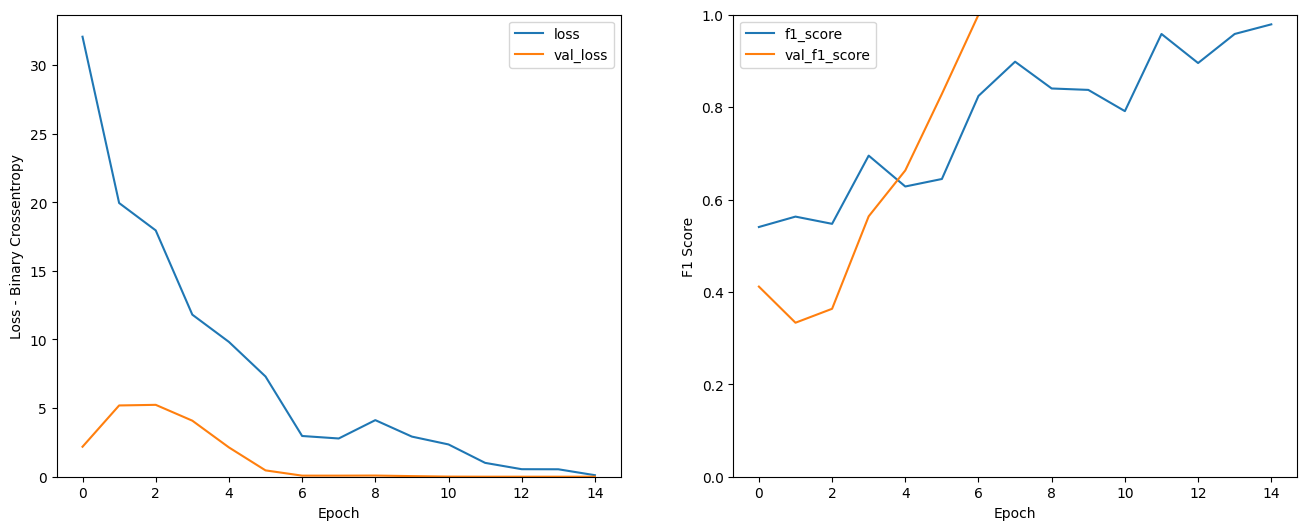

In [43]:
%matplotlib inline
plot_callbacks_history(fad_history, figsize=(16, 6), eval_metrics=['Binary Crossentropy', 'F1 Score'])

val_dicts for evaluating results for each label are not necessary for this since there's only 2 labels; also the f1 scores are almost perfect.

### <b>10. Conclusion</b>

summary of the results and its meaning/potential impact
- Voice Cloning (VC) system
	- evaluate the quality of speech generation part by evaluating transcription of the generated speech. result?
	- speaker classification accuracy to assess the performance of the generated audio's target speaker. result?
- Fake Audio Detection (FAD) system
	- evaluate performance using F-1score

learning points/challenges

future iteration/application